In [14]:
%load_ext autoreload
%autoreload 2    
import flopy
import os
import sys
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import glob
if sys.platform.lower()=='linux':
    datadir = Path('/scratch/users/ianpg/SWIlarge/data')
    workdir = Path('/scratch/users/ianpg/SWIlarge/work')
    MPSdir = datadir.joinpath('lith/sgems/MPS')
    lithdir = datadir.joinpath('lith/sgems/')
    GISdir = datadir.joinpath('GIS')
    priordir = datadir.joinpath('PriorModel')
    modeldir = datadir.joinpath('NM_model')
elif sys.platform.lower()=='darwin':
    datadir = Path('../data')
    workdir = Path('../work')
    MPSdir = Path('/Users/ianpg/Dropbox/temp_convenience/SWIlarge/data/lith/sgems/MPS')
    GISdir = datadir.joinpath('GIS')
    lithdir = datadir.joinpath('lith/sgems/')
    priordir = datadir.joinpath('PriorModel')
    modeldir = datadir.joinpath('NM_model')

nmgwmdir_empty = datadir.joinpath('nmgwmdir_empty') #<-- removed everything but DIS
nmgwmdir_cal = datadir.joinpath('Calibrated_small') #<-- removed RCH, WEL, GLO, LST from the NAM file to load much faster
figdir = workdir.joinpath('figs')
outputdir = workdir.joinpath('output')

import config

In [15]:
#%% Useful functions
def load_obj(dirname,name):
    import pickle
    with open(Path(dirname).joinpath(name + '.pkl').as_posix(), 'rb') as f:
        return pickle.load(f)

def save_obj(dirname,obj,name):
    import pickle
    with open(Path(dirname).joinpath(name + '.pkl').as_posix(), 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def make_timestamp(YMD=True,HM=True):
    import datetime
    if YMD:
        ymd = '%Y%m%d'
    else:
        ymd = ''
    if HM:
        hm = '%H%M'
    else:
        hm = ''
    if YMD and HM:
        sep = '_'
    else:
        sep = ''
    return datetime.datetime.now().strftime('{}{}{}'.format(ymd,sep,hm))


### Load salinity data and success/failure of runs

##### Find data files

In [76]:
job_id = 3573022
case='SV'

# job_id = 3573239
# case='NM'

## Find AEM data files
ouput_AEM = Path('/scratch/users/ianpg/SWIlarge/work/output/AEM/data/')
aempaths = glob.glob(ouput_AEM.joinpath('{case}*_{job_id}.npy'.format(case=case,job_id=job_id)).as_posix())
its_AEM = np.array([int(f.split('_')[-2]) for f in aempaths])

output_case = Path('/scratch/users/ianpg/SWIlarge/work/output/{}'.format(case))
f_varlist = Path('../data/PriorModel/varlist.pkl')
varlist = load_obj(f_varlist.parent,'varlist')

ucnpaths = glob.glob(output_case.joinpath('*_{job_id}.UCN'.format(job_id=job_id)).as_posix())
totims = np.array([int([s for s in f.split('_') if 'totim' in s][0].lstrip('totim')) for f in ucnpaths])
its_tds = np.array([int(f.split('_')[0].split('/')[-1].lstrip('conc')) for f in ucnpaths])
success_AEM = np.array([True if it in its_AEM else False for it in its_tds])
failed = totims<14782
its_failed = its_tds[failed]
its_success = its_tds[~failed]

strange = [(it in its_failed) for it in its_AEM]
if np.any(strange):
    print('something weird here... failed seawat run ended up with AEM data?')
    
print('Case: {} Failure rate: {} %'.format(case,np.round(100*sum(failed)/len(failed),2)))


Case: SV Failure rate: 4.47 %


##### Load the data

In [77]:
print('loading...')
'''
d_conc and d_AEM stored by iteration number so there are some empty indices along first axis corresponding to its_failed
'''
# d_conc = np.zeros((500,20, 19, 345),dtype=np.float)
# d_conc_flat = np.zeros((500,20, 19, 345),dtype=np.float)


# d_AEM = np.zeros((500,2940),dtype=np.float) 
flag=0
for f,it_AEM in zip(aempaths,its_AEM):
    if flag==0:
        matshape_AEM = np.load(f).shape
        matsize_AEM= np.prod(matshape_AEM)
        d_AEM = np.zeros((max(its_tds+1),matsize_AEM),dtype=np.float) 
        flag=1
    d_AEM[it_AEM] = np.load(f,allow_pickle=True)


flag=0
for f,it_tds,it_inAEM in zip(ucnpaths,its_tds,success_AEM):        
    if it_inAEM:
        if flag==0:
            matshape_conc = np.load(f.rstrip('UCN') + 'npy').shape
            matsize_conc = np.prod(matshape_conc)
            d_conc = np.zeros((max(its_tds+1),matsize_conc))
            flag=1
        d_conc[it_tds] = np.load(f.rstrip('UCN') + 'npy').flatten()

        

#Verify that mats have missing rows in same indices
if (np.where(~d_conc.any(axis=1))[0] ==  np.where(~d_AEM.any(axis=1))[0]).all():
    print('matrices line up!')
else:
    print('Warning: matrices do not line up!')        
        
        
keep_inds = np.where(d_conc.any(axis=1))[0]
d_AEM = -d_AEM[keep_inds,:]
d_conc = d_conc[keep_inds,:]
its_AEM = np.sort(its_AEM)
its_tds = np.sort(its_tds[success_AEM])

#Load observed data
d_obs = np.load(datadir.joinpath('AEM','dobs_{}.npy'.format(case)))
area_304 = 337.04
invalid_msk= d_obs==9999./area_304
invalid_inds = np.unique(np.r_[np.where(invalid_msk)[0], np.where(np.isnan(d_AEM[0]))[0]])


#Remove invalid data
d_obs[invalid_inds]=0.
d_AEM[:,invalid_inds]=0.

#Take the log
d_obs[d_obs!=0]=np.log(d_obs[d_obs!=0])
d_AEM[d_AEM!=0]=np.log(d_AEM[d_AEM!=0])




loading...
matrices line up!


##### Load in thickness of 180/400-FA or salinity of 180-FA

In [78]:
if case=='NM':
    pass
elif case=='SV':
    pass

##### Dim reduction

In [80]:
#FROM AUTOBEL

autobeldir = 'source_code/'
if autobeldir not in sys.path:
    sys.path.insert(0,autobeldir)
    
    
import numpy as np
from sklearn.decomposition import PCA

from source_code.scree_plot import scree_plot
from source_code.evd_fast import *


# from source_code.combine_mc_samples import *
# from source_code.signed_distance_functions import *
# from source_code.giip_cal import *

# from source_code.gd_wellog_data import gd_wellog_data
# from source_code.DGSA_light import DGSA_light
# from source_code.gsa_pareto_plt import gsa_pareto_plt
# from source_code.falsifications import fals_1Dplt, fals_2Dplt
# from source_code.outlier_detection import outlier_2d
# from source_code.RobustMD_flsification import RobustMD_flsification
# from source_code.rgrplt_all_dh import rgrplt_all_dh 
# from source_code.cca_and_ccaplt import cca_d_h
# from source_code.cca_and_ccaplt import cca_plt
# from source_code.gaussianregression_c_dd_star import *
# from source_code.post_est_rtn_val import post_est_rtn_val
# from source_code.post_est_rtn_val import post_est_clsplt
# from source_code.plt_pos_pri_comp import plt_pos_pri_comp
# from source_code.plt_MC_models_smpls import m_ensampl_plt
# from source_code.plt_MC_models_smpls import mc_samples_plot
# from source_code.qc_reslts_plt import m_ensampl_plt

'''
# model_names: names of the input models, type - list
model_names =['thickness']
# Define model type: 1 - Continous; 2 - Categorical
model_types = [1]
# Define model dimensions in x, y, z directions. 
x_dim, y_dim, z_dim = 200, 100, 1
# Define model horizontal resolution
grid_h_resolution = 250*250
# Provide directory of the prior models
pri_m_samples_dir = 'input/prior_samples/'
# Provide sample size of the prior models
samples_size = 250
# Provide directory of the global parameters
mgl = 'input/thickness_mgl.txt'
# Provide directory of the data observation
dobs_file = 'input/thickness_obs'
'''

"\n# model_names: names of the input models, type - list\nmodel_names =['thickness']\n# Define model type: 1 - Continous; 2 - Categorical\nmodel_types = [1]\n# Define model dimensions in x, y, z directions. \nx_dim, y_dim, z_dim = 200, 100, 1\n# Define model horizontal resolution\ngrid_h_resolution = 250*250\n# Provide directory of the prior models\npri_m_samples_dir = 'input/prior_samples/'\n# Provide sample size of the prior models\nsamples_size = 250\n# Provide directory of the global parameters\nmgl = 'input/thickness_mgl.txt'\n# Provide directory of the data observation\ndobs_file = 'input/thickness_obs'\n"

In [46]:
def eigen_imgs_local(eigen_vecs, eig_nums,matshape,slicenum=10):
    '''
    This is the function to plot the eigen_images
    arg:
        eigen_vecs: the ndarray of the eigen vectors
        eig_nums: 1d arrary defines which pc numbers to plot
        i_dim, j_dim: the i and j dimension of the grid model        
    '''
    plot_num = len(eig_nums)
    fig_row = int((plot_num+3)/4)
    fig=plt.figure(figsize=(15, fig_row*3))
    
    count = 1
    for i in eig_nums:
        plot=fig.add_subplot(fig_row, 4, count)
        count = count+1
        plt.imshow(eigen_vecs[:,i].reshape(matshape)[:,slicenum,:], cmap='jet')  
        plt.gca().set_aspect(7)
        plt.xticks(fontsize = 13)
        plt.yticks(fontsize = 13)
        plt.title('model eigen_img (PC' + str(i) +')', fontsize = 14)
    plt.subplots_adjust(top=0.55, bottom=0.08, left=0.10, right=0.95, hspace=0.15,
                    wspace=0.35)
    
    #t = (" ")
    #plt.figure(figsize=(3, 0.1))
    #plt.text(0, 0, t, style='normal', ha='center', fontsize=16, weight = 'bold')
    #plt.setp(plt.gca(), frame_on=False, xticks=(), yticks=())
    #plt.show()
    return

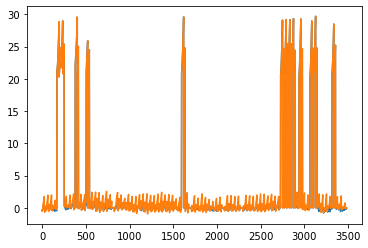

In [133]:
plt.plot(d_AEM[269]-d_obs)
plt.plot(d_AEM[150]-d_obs)



  
3. Dimension reduction of model and data
2020-07-05 11:50:46:283223
2020-07-05 11:50:57:880796
QC of the model eigen images


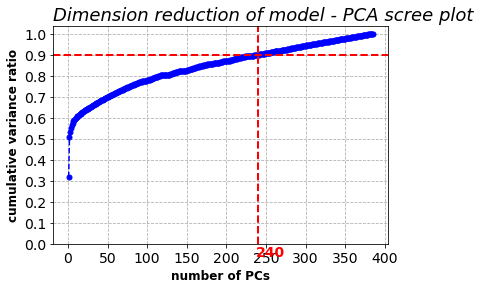

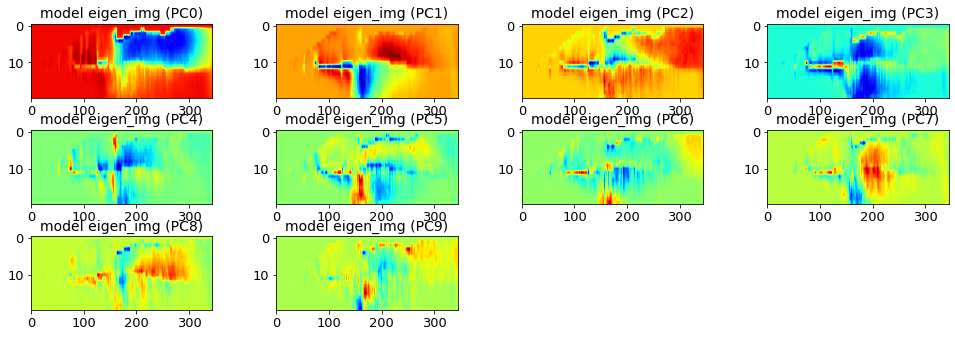

In [141]:
print("  ")
print("3. Dimension reduction of model and data")
'''m_pcnumsc: the number of model PCs to preserve in dimension reduction'''

model_name = 'test'

m_pcnums = []
m_pri = d_conc
d_pri = d_AEM

m_pcnum =scree_plot(m_pri, 'model', 90, 'plot')
m_pcnums.append(m_pcnum)
m_mean_pri = m_pri.mean(axis=0)
m_eigvec_pri = evd_fast(m_pri, len(m_pri))
m_pcscr_pri=(m_pri-m_mean_pri).dot(m_eigvec_pri)

output_model = outputdir.joinpath('BEL',case,'model')
output_data = outputdir.joinpath('BEL',case,'data')

if not output_model.exists():
    output_model.mkdir(parents=True)
if not output_data.exists():
    output_data.mkdir(parents=True)



    
np.save(output_model.joinpath('{}_mean_pri.npy'.format(model_name)), m_mean_pri)
np.save(output_model.joinpath('{}_eigvec_pri.npy'.format(model_name)), m_eigvec_pri)
np.save(output_model.joinpath('{}_pcscr_pri.npy'.format(model_name)), m_pcscr_pri)

print("QC of the model eigen images")
eigen_imgs_local(m_eigvec_pri, np.arange(10), matshape_conc)





#Data PCA
d_pca = PCA(n_components=d_pri.shape[0])
d_pca.fit(d_pri)
d_pcscr = d_pca.transform(d_pri)

np.save(output_data.joinpath('{}_dpcscr_pri.npy'.format(model_name)), d_pcscr)
np.save(output_data.joinpath('{}_dpcscr_obs.npy'.format(model_name)), d_pcscr_obs)
np.save(output_data.joinpath('{}_dpca_eigenvec.npy'.format(model_name)), d_pca.components_)


##### Load observed data

##### Mahabonabonlis distance

In [42]:
m_eigvec_pri.shape

(131100, 231)

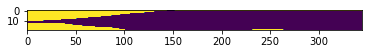

In [41]:
plt.imshow(d_conc[0].reshape(matshape_conc)[:,0,:])

### Plot

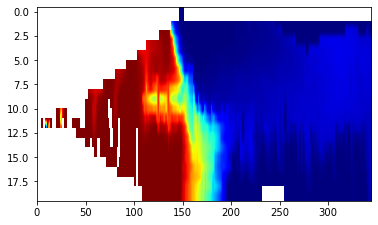

In [94]:
conc[conc>100]=np.nan

plt.imshow(conc[:,10,:],vmin=0,vmax=35.,cmap='jet')
plt.gca().set_aspect(10)

In [76]:
for f in ucn

TypeError: only integer scalar arrays can be converted to a scalar index

In [74]:
dd = {}

for 



233

In [59]:
data

In [19]:
ucnpaths = glob.glob(output_SV.joinpath('*_{}.UCN'.format(job_id)).as_posix())
f= ucnpaths[0]
f.split('_')

['/scratch/users/ianpg/SWIlarge/work/output/SV/conc75',
 '20200704',
 '1110',
 'totim14782',
 '3573022.UCN']

In [25]:
totims = np.array([int([s for s in f.split('_') if 'totim' in s][0].lstrip('totim')) for f in ucnpaths])
